In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
SHAPE = 256
SPLIT_SIZE = 0.9

## defining a frame for image and mask storage
framObj = {'img' : [],
           'mask' : []
          }

framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

In [3]:
## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = SHAPE): ### !!! SPLIT DATASET
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.jpg', '.png', mem))
    
    ## defining images and labels path
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    ## loop all images
    for i in range (len(imgNames)):
        try:
            ## read an image and the corresponding label
            img = plt.imread(imgAddr + imgNames[i])
            mask = plt.imread(maskAddr + maskNames[i])
            
            ## normalize image color
            img = img/255.0
            
            ## resize image dimension to SHAPE x SHAPE
            img = cv2.resize(img, (shape, shape))
            mask = cv2.resize(mask, (shape, shape))
        except:
            continue
    
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [4]:
## defining data Split function
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    i = 0
    # split
    train_size = int(len(SOURCE['mask']) * SPLIT_SIZE)

    for img in SOURCE['img']:
        if i <= train_size:
            TRAINING['img'].append(img)
        else: 
            # Switch copy target to TESTING
            VALIDATION['img'].append(img)
        i += 1

    i = 0
    for mask in SOURCE['mask']:
        if i <= train_size:
            TRAINING['mask'].append(mask)
        else: 
            # Switch copy target to TESTING
            VALIDATION['mask'].append(mask)
        i += 1

    return TRAINING, VALIDATION

In [5]:
framObj = LoadData(framObj, ### !!! IMPLEMENT CHANGED METHOD
                    imgPath = 'dataset/images', 
                    maskPath = 'dataset/labels_only_clothing',
                    shape = SHAPE)

# print(len(framObj['img']))

In [6]:
framObjTrain, framObjValidation = split_data(SOURCE = framObj, 
                                            TRAINING = framObjTrain, 
                                            VALIDATION = framObjValidation, 
                                            SPLIT_SIZE = SPLIT_SIZE)

# print(len(framObjTrain['img']))
# print(len(framObjTrain['mask']))

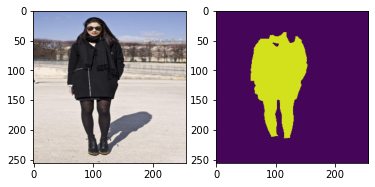

In [7]:
## displaying data loaded by our function
import random
n = random.randint(0,100)

plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][n])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][n])
plt.show()

In [8]:
## defining our CNN for encoding and decoding

myTransformer = tf.keras.models.Sequential([ ### !!! TRY DIFFERENT ARCHITECTURE
    ## defining encoder 
    tf.keras.layers.Input(shape= (SHAPE, SHAPE, 3)),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'valid'),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    
    ## defining decoder path
    tf.keras.layers.UpSampling2D(size = (2,2)),
    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    
    tf.keras.layers.UpSampling2D(size = (2,2)),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.UpSampling2D(size = (2,2)),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.UpSampling2D(size = (2,2)),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(filters = 3, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    
    
    
])

In [9]:
myTransformer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        3

In [10]:
myTransformer.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5), ### !!! TRY DIFFERENT ALGORITHM
    loss = 'mean_absolute_error', ### !!! TRY DIFFERENT ALGORITHM
    metrics = ['acc'])

In [11]:
#Training Data
retVal = myTransformer.fit(np.array(framObjTrain['img']),
                           np.array(framObjTrain['mask']),
                           batch_size=16, ### !!! TRY DIFFERENT BATCH SIZE
                           ### !!! ADD VALIDATION DATASET
                           epochs = 50, ### !!! CHANGE BACK TO 100
                           validation_data=(np.array(framObjValidation['img']), np.array(framObjValidation['mask']))
                           )

Epoch 1/50
57/57 [==============================] - 18s 199ms/step - loss: 0.1857 - acc: 0.5445 - val_loss: 0.1308 - val_acc: 0.8245
Epoch 2/50
57/57 [==============================] - 8s 146ms/step - loss: 0.1105 - acc: 0.8311 - val_loss: 0.1034 - val_acc: 0.8325
Epoch 3/50
57/57 [==============================] - 8s 148ms/step - loss: 0.1007 - acc: 0.8347 - val_loss: 0.0982 - val_acc: 0.8328
Epoch 4/50
57/57 [==============================] - 8s 148ms/step - loss: 0.0967 - acc: 0.8349 - val_loss: 0.0955 - val_acc: 0.8329
Epoch 5/50
57/57 [==============================] - 9s 155ms/step - loss: 0.0948 - acc: 0.8350 - val_loss: 0.0945 - val_acc: 0.8329
Epoch 6/50
57/57 [==============================] - 9s 157ms/step - loss: 0.0931 - acc: 0.8350 - val_loss: 0.0926 - val_acc: 0.8330
Epoch 7/50
57/57 [==============================] - 10s 178ms/step - loss: 0.0919 - acc: 0.8379 - val_loss: 0.0939 - val_acc: 0.8364
Epoch 8/50
57/57 [==============================] - 12s 206ms/step - loss:

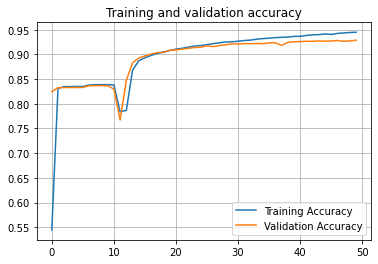

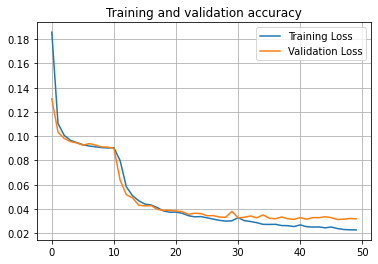

In [12]:
acc = retVal.history['acc']
val_acc = retVal.history['val_acc']
loss = retVal.history['loss']
val_loss = retVal.history['val_loss']

epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
def predict16 (valMap, model, shape = SHAPE):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [14]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)

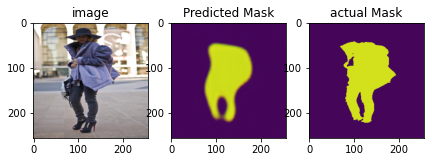

In [15]:
n_r = random.randint(0,15)

Plotter(actuals[n_r], sixteenPrediction[n_r], masks[n_r])

In [16]:
def read_img(path, shape):
    img = plt.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (shape, shape))
    
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[[233 235 236]
   [233 235 236]
   [233 235 236]
   ...
   [228 230 231]
   [228 230 231]
   [228 230 231]]

  [[233 235 236]
   [233 235 236]
   [233 235 236]
   ...
   [228 230 231]
   [228 230 231]
   [228 230 231]]

  [[233 235 236]
   [233 235 236]
   [233 235 236]
   ...
   [228 230 231]
   [228 230 231]
   [228 230 231]]

  ...

  [[228 230 231]
   [228 230 231]
   [228 230 231]
   ...
   [227 229 230]
   [227 229 230]
   [227 229 230]]

  [[228 230 231]
   [228 230 231]
   [228 230 231]
   ...
   [227 229 230]
   [227 229 230]
   [227 229 230]]

  [[228 230 231]
   [228 230 231]
   [228 230 231]
   ...
   [227 229 230]
   [227 229 230]
   [227 229 230]]]]


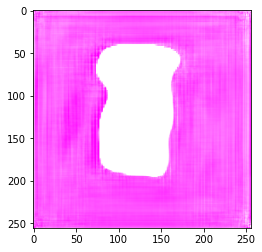

In [17]:
clothes = read_img("dataset/testing/Hoodie.jpg", SHAPE)
clothes = np.array([clothes])
clothes_mask = myTransformer.predict(clothes)
print(clothes)
# plt.imshow(clothes[0])
plt.imshow(clothes_mask[0])

In [18]:
# show the image, provide window name first
# cv2.imshow('image window', sixteenPrediction[n_r])
# # add wait key. window waits until user presses a key
# cv2.waitKey(0)
# # and finally destroy/close all open windows
# cv2.destroyAllWindows()

In [19]:
save_file = 'save_model/model_003.h5'
myTransformer.save(save_file)